In [232]:
import numpy as np
import dataloader
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import models
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision
import os
import time
from torch_geometric.nn import GATv2Conv, global_mean_pool
# reload library
import importlib
import cv2
#import utils as ut
import pandas as pd
import DataDLC
from torch_geometric.data import Data, DataLoader
import tqdm


# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

In [233]:
importlib.reload(dataloader)
importlib.reload(DataDLC)
importlib.reload(models)

<module 'models' from 'c:\\Users\\Usuario\\Documents\\Documents\\MVA\\Stage\\DLCProject\\Code\\GitHubRep\\Behavioral_Tagging_of_Mice_in_multiple_Mice_dataset_using_Deep_Learning\\src\\models.py'>

In [234]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# Load the data
dataset = torch.load(r'c:\Users\Usuario\Documents\Documents\MVA\Stage\DLCProject\Data\DataLoaderTestFormat\dataset.pkl', map_location=device)

cpu


C:\Users\Usuario\AppData\Local\Temp\ipykernel_14948\295618481.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dataset = torch.load(r'c:\Users\Usuario\Documents\Documents

In [311]:
# Get the first graph in the dataset
data = dataset[56].clone()

In [312]:
#data = dataset[10].clone()

In [313]:
data

Data(x=[180, 4], edge_index=[2, 3718], file='DMD_mal_Test_1DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5', frame_mask=[180], behaviour=[11], behaviour_names=Index(['General_Contacts', 'Sniffing_R', 'Poursuit_R', 'Dominance_R',
       'Rearing_R', 'Grooming_R', 'Sniffing_V', 'Poursuit_V', 'Dominance_V',
       'Rearing_V', 'Grooming_V'],
      dtype='object'))

In [314]:
data.behaviour_names

Index(['General_Contacts', 'Sniffing_R', 'Poursuit_R', 'Dominance_R',
       'Rearing_R', 'Grooming_R', 'Sniffing_V', 'Poursuit_V', 'Dominance_V',
       'Rearing_V', 'Grooming_V'],
      dtype='object')

In [315]:
data.frame_mask

tensor([56, 57, 58, 59, 60, 56, 57, 58, 59, 60, 56, 57, 58, 59, 60, 56, 57, 58,
        59, 60, 56, 57, 58, 59, 60, 56, 57, 58, 59, 60, 56, 57, 58, 59, 60, 56,
        57, 58, 59, 60, 56, 57, 58, 59, 60, 56, 57, 58, 59, 60, 56, 57, 58, 59,
        60, 56, 57, 58, 59, 60, 56, 57, 58, 59, 60, 56, 57, 58, 59, 60, 56, 57,
        58, 59, 60, 56, 57, 58, 59, 60, 56, 57, 58, 59, 60, 56, 57, 58, 59, 60,
        56, 57, 58, 59, 60, 56, 57, 58, 59, 60, 56, 57, 58, 59, 60, 56, 57, 58,
        59, 60, 56, 57, 58, 59, 60, 56, 57, 58, 59, 60, 56, 57, 58, 59, 60, 56,
        57, 58, 59, 60, 56, 57, 58, 59, 60, 56, 57, 58, 59, 60, 56, 57, 58, 59,
        60, 56, 57, 58, 59, 60, 56, 57, 58, 59, 60, 56, 57, 58, 59, 60, 56, 57,
        58, 59, 60, 56, 57, 58, 59, 60, 56, 57, 58, 59, 60, 56, 57, 58, 59, 60],
       dtype=torch.int32)

In [316]:
node_features = data.x
edge_index = data.edge_index
frame_mask = data.frame_mask

In [317]:
def is_undirected(edge_index):
    # Sort the edges to ensure each pair (u, v) and (v, u) is in the same order.
    sorted_edges = edge_index.t().sort(dim=1)[0]
    
    # Find unique edges and count their occurrences.
    unique_edges, counts = torch.unique(sorted_edges, dim=0, return_counts=True)
    
    # For the graph to be undirected, each unique edge should appear twice.
    return torch.all(counts == 2), unique_edges, counts

flag, unique_edges, counts = is_undirected(edge_index)



In [318]:
print(counts.unique())

tensor([1, 2])


In [319]:
# print the edges that have other than 2 counts and their counts
print(len(unique_edges[counts == 2]))

1769


In [320]:
edge_index = edge_index.numpy()

In [321]:
# Plot the graph
import matplotlib.pyplot as plt
import networkx as nx

G = nx.Graph()
G1 = nx.Graph()
G.add_nodes_from(range(node_features.shape[0]))
G1.add_nodes_from(range(node_features.shape[0]))
edge_color = []
edge1_color = []
edges = []
for edge in edge_index.T:
    #if node_features[edge[0], 4] != node_features[edge[1], 4]:
    if frame_mask[edge[0]] != frame_mask[edge[1]]:
        G1.add_edge(edge[0], edge[1], color='y')
        edges.append((edge[0], edge[1]))
        edge1_color.append('y')
        print('r')
    else:
        edges.append((edge[0], edge[1]))
        G.add_edge(edge[0], edge[1], color='k')
        edge_color.append('k')

#G.add_edges_from(edge_index.T.tolist())

r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r


In [322]:
G.nodes

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179))

In [323]:
node_features[:,3]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [324]:
data.frame_mask

tensor([56, 57, 58, 59, 60, 56, 57, 58, 59, 60, 56, 57, 58, 59, 60, 56, 57, 58,
        59, 60, 56, 57, 58, 59, 60, 56, 57, 58, 59, 60, 56, 57, 58, 59, 60, 56,
        57, 58, 59, 60, 56, 57, 58, 59, 60, 56, 57, 58, 59, 60, 56, 57, 58, 59,
        60, 56, 57, 58, 59, 60, 56, 57, 58, 59, 60, 56, 57, 58, 59, 60, 56, 57,
        58, 59, 60, 56, 57, 58, 59, 60, 56, 57, 58, 59, 60, 56, 57, 58, 59, 60,
        56, 57, 58, 59, 60, 56, 57, 58, 59, 60, 56, 57, 58, 59, 60, 56, 57, 58,
        59, 60, 56, 57, 58, 59, 60, 56, 57, 58, 59, 60, 56, 57, 58, 59, 60, 56,
        57, 58, 59, 60, 56, 57, 58, 59, 60, 56, 57, 58, 59, 60, 56, 57, 58, 59,
        60, 56, 57, 58, 59, 60, 56, 57, 58, 59, 60, 56, 57, 58, 59, 60, 56, 57,
        58, 59, 60, 56, 57, 58, 59, 60, 56, 57, 58, 59, 60, 56, 57, 58, 59, 60],
       dtype=torch.int32)

In [325]:
# The position of the nodes is the node features (first two dimensions), add +1 in x coord for different frames
# Put different colors to the nodes depending on the node features
colors = node_features[:, 3].numpy()
# if colors is 0 -> red, if 1 -> yellow
colors = ['r' if c == 0 else 'b' for c in colors]

# Node sizes
size = 100
# alpha of the edges
alpha = 0.3
# Position of the nodes
pos = node_features[:, :2].numpy()
# Add data.frame_mask to the x coordinate
# Frame difference
frame_x_diff = data.frame_mask.numpy().copy()
# Normalize the frame difference
frame_x_diff = ((frame_x_diff - frame_x_diff.min())*2) / (frame_x_diff.max() - frame_x_diff.min())
pos[:, 0] += frame_x_diff


In [326]:
frame_x_diff

array([0. , 0.5, 1. , 1.5, 2. , 0. , 0.5, 1. , 1.5, 2. , 0. , 0.5, 1. ,
       1.5, 2. , 0. , 0.5, 1. , 1.5, 2. , 0. , 0.5, 1. , 1.5, 2. , 0. ,
       0.5, 1. , 1.5, 2. , 0. , 0.5, 1. , 1.5, 2. , 0. , 0.5, 1. , 1.5,
       2. , 0. , 0.5, 1. , 1.5, 2. , 0. , 0.5, 1. , 1.5, 2. , 0. , 0.5,
       1. , 1.5, 2. , 0. , 0.5, 1. , 1.5, 2. , 0. , 0.5, 1. , 1.5, 2. ,
       0. , 0.5, 1. , 1.5, 2. , 0. , 0.5, 1. , 1.5, 2. , 0. , 0.5, 1. ,
       1.5, 2. , 0. , 0.5, 1. , 1.5, 2. , 0. , 0.5, 1. , 1.5, 2. , 0. ,
       0.5, 1. , 1.5, 2. , 0. , 0.5, 1. , 1.5, 2. , 0. , 0.5, 1. , 1.5,
       2. , 0. , 0.5, 1. , 1.5, 2. , 0. , 0.5, 1. , 1.5, 2. , 0. , 0.5,
       1. , 1.5, 2. , 0. , 0.5, 1. , 1.5, 2. , 0. , 0.5, 1. , 1.5, 2. ,
       0. , 0.5, 1. , 1.5, 2. , 0. , 0.5, 1. , 1.5, 2. , 0. , 0.5, 1. ,
       1.5, 2. , 0. , 0.5, 1. , 1.5, 2. , 0. , 0.5, 1. , 1.5, 2. , 0. ,
       0.5, 1. , 1.5, 2. , 0. , 0.5, 1. , 1.5, 2. , 0. , 0.5, 1. , 1.5,
       2. , 0. , 0.5, 1. , 1.5, 2. , 0. , 0.5, 1. , 1.5, 2. ])

In [327]:
pos

array([[0.86908126, 0.19898333],
       [1.3649235 , 0.19898333],
       [1.8307531 , 0.321275  ],
       [2.3065813 , 0.393025  ],
       [2.8021545 , 0.43483126],
       [0.81175154, 0.21294166],
       [1.3117516 , 0.21851666],
       [1.8122735 , 0.25868958],
       [2.321311  , 0.32279792],
       [2.8213906 , 0.37240416],
       [0.82293284, 0.2845979 ],
       [1.3185766 , 0.2845979 ],
       [1.7842828 , 0.3233979 ],
       [2.2765718 , 0.35134375],
       [2.7743454 , 0.3883604 ],
       [0.83711565, 0.23425625],
       [1.3357891 , 0.23425625],
       [1.8141968 , 0.2995729 ],
       [2.30985   , 0.35539374],
       [2.8007016 , 0.39979374],
       [0.7739625 , 0.19506459],
       [1.2745702 , 0.20096876],
       [1.7872281 , 0.21630625],
       [2.307272  , 0.26305208],
       [2.818442  , 0.30724582],
       [0.78348905, 0.3065    ],
       [1.283489  , 0.3065    ],
       [1.7653437 , 0.32699582],
       [2.2533984 , 0.33097917],
       [2.7533984 , 0.34882918],
       [0.

In [328]:
# count values of data.frame_mask.numpy()
unique, counts = np.unique(data.frame_mask.numpy(), return_counts=True)
dict(zip(unique, counts))


{56: 36, 57: 36, 58: 36, 59: 36, 60: 36}

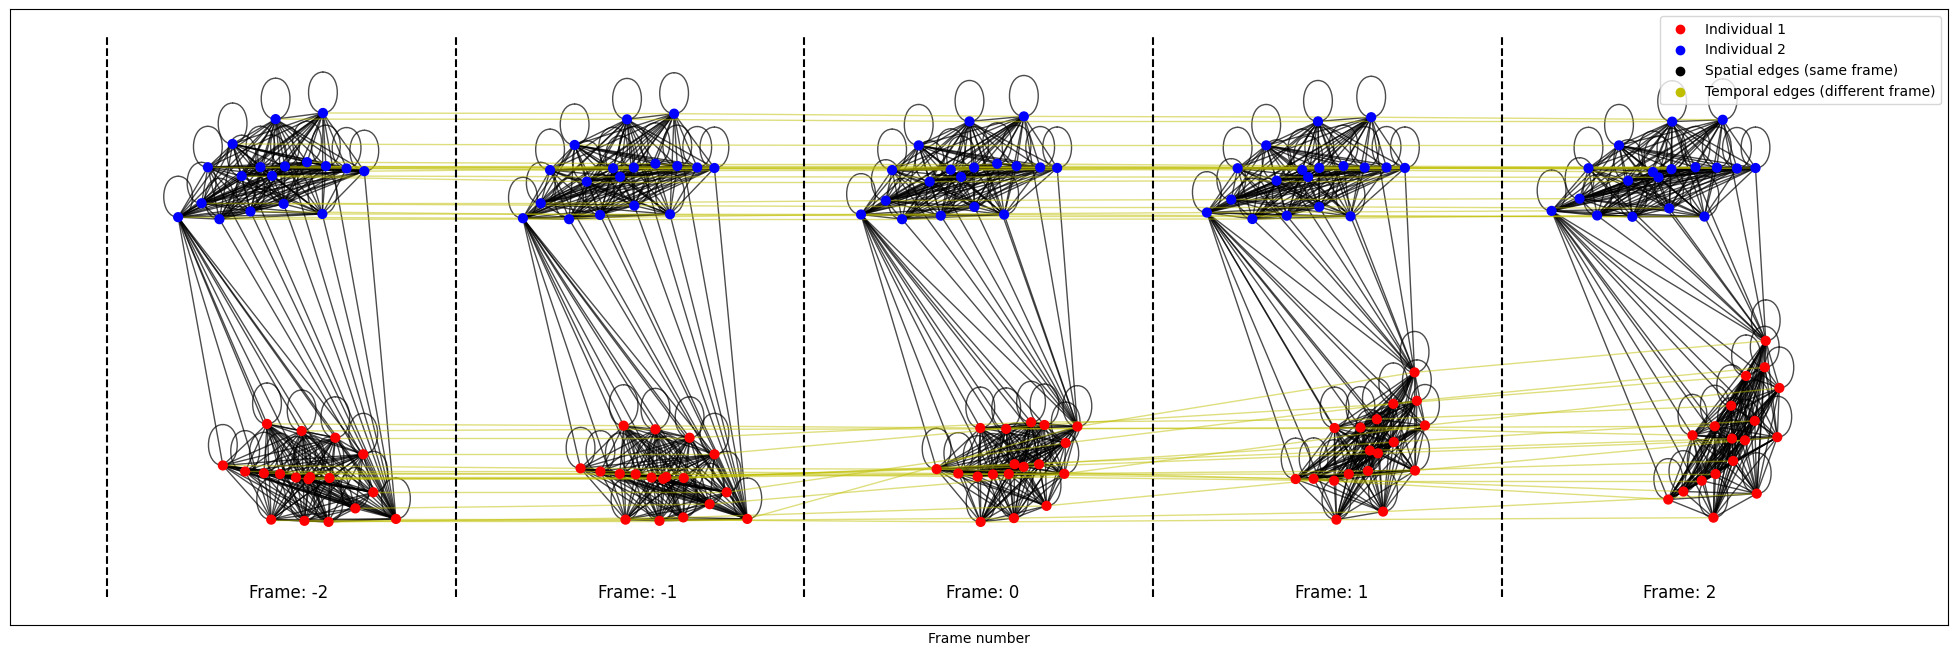

In [329]:
# Plot the graph
plt.figure(figsize=(25, 8))
#pos = nx.spring_layout(G)
#nx.draw(G, pos, node_size=50, node_color=colors, alpha = 0.3)

nx.draw_networkx_edges(G, pos, alpha=0.7, edge_color=edge_color)
nx.draw_networkx_edges(G1, pos, alpha=0.5, edge_color=edge1_color)
#nx.draw(G, pos, node_size=50, node_color=colors)
nx.draw_networkx_nodes(G, pos, node_size=40, node_color=colors)
# legend for the nodes
plt.scatter([],[], c='r', label='Individual 1')
plt.scatter([],[], c='b', label='Individual 2')
# legend for the edges
plt.scatter([],[], c='k', label='Spatial edges (same frame)')
plt.scatter([],[], c='y', label='Temporal edges (different frame)')
# Plot an discrete x axis to show the frames
centers = np.arange(pos[:, 0].min() -0.1, pos[:, 0].max() + 0.1, (pos[:, 0].max() - pos[:, 0].min() + 0.2)/5)
frames = ['Frame: -2', 'Frame: -1', 'Frame: 0', 'Frame: 1', 'Frame: 2']

num_frames = 5
for i in range(num_frames):
    plt.text(centers[i]+0.2, pos[:, 1].min() - 0.1, frames[i], fontsize=12)
    plt.plot([centers[i], centers[i]], [pos[:, 1].min() - 0.1, pos[:, 1].max() + 0.1], 'k--')
# Indicate the frame number
plt.xlabel('Frame number')
# center th x axis in
plt.legend(loc='upper right')
plt.show()

In [105]:
# Lets only plot the nodes that are in a same frame
nodes_features_to_keep = node_features[node_features[:,4]==0]

IndexError: index 4 is out of bounds for dimension 1 with size 4

In [ ]:
nodes_features_to_keep.shape

In [820]:
# edge_index of the nodes that are in the same frame
G = nx.Graph()

# Get the indices of the nodes that are in the same frame
nodes_in_frame = np.where(node_features[:,4]==0)[0]
nodes_features_to_keep = node_features[node_features[:,4]==0]

G.add_nodes_from(nodes_in_frame)

edge_index = edge_index.numpy()

# Keep only the edges that are between nodes in the same frame
for i in range(edge_index.shape[1]):
    if edge_index[0, i] in nodes_in_frame and edge_index[1, i]in nodes_in_frame:
        G.add_edge(edge_index[0, i], edge_index[1, i])



In [ ]:
G.number_of_nodes()

In [ ]:
G.edges

In [ ]:
nodes_in_frame

In [ ]:
edge_index

In [ ]:
G.nodes

In [ ]:
edge_index[0, 0]
edge_index[1, 0]

In [ ]:
nodes_features_to_keep[:,:2].numpy()

In [ ]:


# The position of the nodes is the node features (first two dimensions), add +1 in x coord for different frames
pos = node_features[:, :2].numpy()
# mappi
colors = nodes_features_to_keep[:, 3].numpy()
# if colors is 0 -> red, if 1 -> yellow
colors = ['r' if c == 0 else 'y' for c in colors]

# Plot
plt.figure(figsize=(25, 8))
nx.draw_networkx_nodes(G, pos, node_size=40, node_color=colors)
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()



## Just Loading a model

In [19]:
import torch
import importlib

In [ ]:
# Load the model
def load_checkpoint(model, optimizer, path, device):
    checkpoint = torch.load(path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    print(f"Checkpoint loaded from {path}, at epoch {epoch}")
    return model, optimizer, epoch

In [4]:
checkpoint = torch.load(r'c:\Users\jalvarez\Documents\checkpoint_epoch_200.pth', map_location='cpu')

In [14]:
checkpoint['model_state_dict']['encoder.gatenc1.att'].shape

torch.Size([1, 2, 16])

In [30]:
import models
importlib.reload(models)

<module 'models' from 'c:\\Users\\jalvarez\\Documents\\Code\\GitHubCOde\\Behavioral_Tagging_of_Mice_in_multiple_Mice_dataset_using_Deep_Learning\\src\\models.py'>

In [41]:
graphencoder = models.GATEncoder_vfollowing(8, 16, 2, 4, dropout=0.5)
class_head = models.ClassificationHead(n_latent=576, nhid = 32, nout = 2)

In [42]:
readout = 'concatenate'
model = models.GraphClassifier(graphencoder, class_head, readout= readout)

In [43]:
for key in checkpoint['model_state_dict']:
    print(key, checkpoint['model_state_dict'][key].shape)

encoder.gatenc1.att torch.Size([1, 2, 16])
encoder.gatenc1.bias torch.Size([32])
encoder.gatenc1.lin_l.weight torch.Size([32, 4])
encoder.gatenc1.lin_l.bias torch.Size([32])
encoder.gatenc1.lin_r.weight torch.Size([32, 4])
encoder.gatenc1.lin_r.bias torch.Size([32])
encoder.gatenc2.att torch.Size([1, 2, 16])
encoder.gatenc2.bias torch.Size([32])
encoder.gatenc2.lin_l.weight torch.Size([32, 32])
encoder.gatenc2.lin_l.bias torch.Size([32])
encoder.gatenc2.lin_r.weight torch.Size([32, 32])
encoder.gatenc2.lin_r.bias torch.Size([32])
encoder.gatenc3.att torch.Size([1, 2, 16])
encoder.gatenc3.bias torch.Size([16])
encoder.gatenc3.lin_l.weight torch.Size([32, 32])
encoder.gatenc3.lin_l.bias torch.Size([32])
encoder.gatenc3.lin_r.weight torch.Size([32, 32])
encoder.gatenc3.lin_r.bias torch.Size([32])
encoder.res_conn.0.weight torch.Size([32, 32])
encoder.res_conn.0.bias torch.Size([32])
classifier.hidden1.weight torch.Size([32, 576])
classifier.hidden1.bias torch.Size([32])
classifier.hidden2

In [44]:
# Print shapes of the model
for name, param in model.named_parameters():
    print(name, param.shape)

encoder.gatenc1.att torch.Size([1, 2, 16])
encoder.gatenc1.bias torch.Size([32])
encoder.gatenc1.lin_l.weight torch.Size([32, 4])
encoder.gatenc1.lin_l.bias torch.Size([32])
encoder.gatenc1.lin_r.weight torch.Size([32, 4])
encoder.gatenc1.lin_r.bias torch.Size([32])
encoder.gatenc2.att torch.Size([1, 2, 16])
encoder.gatenc2.bias torch.Size([32])
encoder.gatenc2.lin_l.weight torch.Size([32, 32])
encoder.gatenc2.lin_l.bias torch.Size([32])
encoder.gatenc2.lin_r.weight torch.Size([32, 32])
encoder.gatenc2.lin_r.bias torch.Size([32])
encoder.gatenc3.att torch.Size([1, 2, 16])
encoder.gatenc3.bias torch.Size([16])
encoder.gatenc3.lin_l.weight torch.Size([32, 32])
encoder.gatenc3.lin_l.bias torch.Size([32])
encoder.gatenc3.lin_r.weight torch.Size([32, 32])
encoder.gatenc3.lin_r.bias torch.Size([32])
encoder.res_conn.0.weight torch.Size([32, 32])
encoder.res_conn.0.bias torch.Size([32])
classifier.hidden1.weight torch.Size([32, 576])
classifier.hidden1.bias torch.Size([32])
classifier.hidden2

In [45]:
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [46]:
# count parameters
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

25362
